# FINAL PROJECT

In this project we will use *Kaggle environments*, in particular this one [ConnectX](https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/connectx/connectx.ipynb).






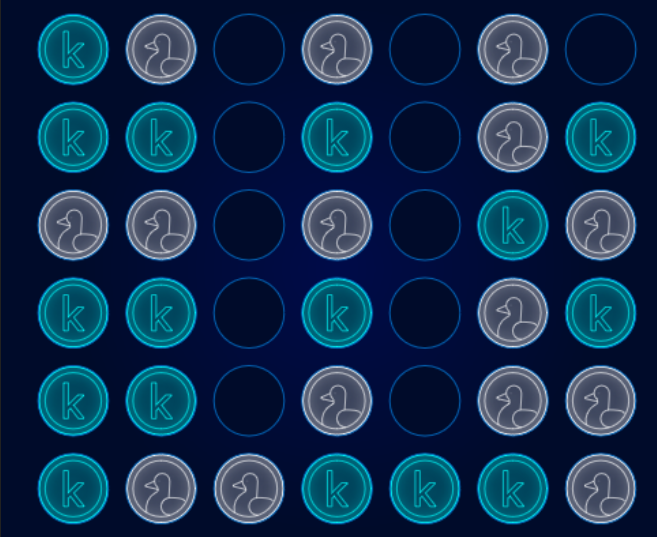

In there, the objective is to create an agent that can play, learn from experience and eventually win (at least against a random player).

## Deliverables:
  1. Your version of this notebook, where you create your agents. You can create as many as you want (from all the algorithms we studied this term), indicating which ones you choose to be tested.

  Alternatively, you might want to submit `python` files for each (class of) agent.
  
  **PGT students** at least have to create 2 agents, where one of them has to be Sarsa($\lambda$).
  
  

  2. After training your agents, you might want to save those learnt values. This can be a dictionary with the `optimal policy`, or `Q-values`. If an approximate method was used, you can provide the `final weights`, etc.

  3. A short report (no more than 10 pages), where you explain your methodology, chosen algorithms, visualisations of the learning process (how rewards increase over time, or how loss functions decrease).

  You should indicate clearly in the report which agents  of all the ones you created, you want to be tested (at most two). You should also explain **why** you chose them.

## Evaluation


Your projects will be evaluated primarily on the development of the agents, not necessarily in their performance. Being said that, better performance will lead in general to better marks.

For example one marking criteria could be to to assign a `70%` to the deliverables pointed out above (where your agents have to run properly, not necessarily win), and the remaining `30%` for performance tests (how good are your agents). In there I will be testing how your agents perform against the two default agents from the environment: `random, negamax`, as well as how they perform against each other, and against a human player.

Final criteria will depend on the overall submissions.

The first line of code install all the `kaggle environments`. If you want to install them locally (and not use Colab), it is the same line if you are using `Jupyter notebooks`.

There are certain advantages to such local installation: for example, training can be faster if you have a reasonable computer. Also, training against a `human player`, only works on local installations. There are of course advantages of using Colab instead (no need to install anything, you can use the lab computers...).

In [27]:
%pip install kaggle-environments --quiet

Note: you may need to restart the kernel to use updated packages.


In [28]:
%pip install pygame

Note: you may need to restart the kernel to use updated packages.


We import the necessary libraries. (run the following cell twice).

In [29]:
from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))

['random', 'negamax']


## Parameters
To make the training a bit easier (less time consuming) we will work on the case of a grid of `4x5` in which you aim to place `3` consecutive pieces (vertical, horizontal or diagonal).

You are welcome to try other dimensions if you want to test your agents in different settings. The design of the agents would not change with the dimensions of the problem, they only will affect the `training phase`.

In [30]:
rows = 4
columns = 5
in_a_row = 3
debug_mode = True


env = make("connectx", {"rows": rows, "columns": columns, "inarow": in_a_row}, steps=[], debug=debug_mode)

The following agent always plays a piece in the 1st column (remember, Python starts counting from 0)

In [31]:
def agent0(observation, configuration):
  print(observation.board) # {board: [...], mark: 1}
  print(configuration) # {rows: 4, columns: 5, inarow: 3}
  return 0 # Action: always place a mark in the 1st column.

# Run an episode using the agent above vs the default random agent.
#env.run([agent0, "random"]) # agent0 is the first player (in blue), random agent is second player (in white)
# You can also try the reverse order
env.run([agent0, 'random'])
env.render(mode="ipython")  # to visualise the outcome



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{'rows': 4, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0]
{'rows': 4, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0]
{'rows': 4, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0]
{'rows': 4, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
Invalid Action: Invalid column: 0


The following code shows what are the components of the different observations, configurations and actions.

In [32]:
# Print schemas from the specification.
env.specification.observation

{'remainingOverageTime': {'description': 'Total remaining banked time (seconds) that can be used in excess of per-step actTimeouts -- agent is disqualified with TIMEOUT status when this drops below 0.',
  'shared': False,
  'type': 'number',
  'minimum': 0,
  'default': 60},
 'step': {'description': 'Current step within the episode.',
  'type': 'integer',
  'shared': True,
  'minimum': 0,
  'default': 0},
 'board': {'description': 'Serialized grid (rows x columns). 0 = Empty, 1 = P1, 2 = P2',
  'type': 'array',
  'shared': True,
  'default': []},
 'mark': {'defaults': [1, 2],
  'description': 'Which checkers are the agents.',
  'enum': [1, 2]}}

In [33]:
env.specification.configuration

{'episodeSteps': {'description': 'Maximum number of steps in the episode.',
  'type': 'integer',
  'minimum': 1,
  'default': 1000},
 'actTimeout': {'description': 'Maximum runtime (seconds) to obtain an action from an agent.',
  'type': 'number',
  'minimum': 0,
  'default': 2},
 'runTimeout': {'description': 'Maximum runtime (seconds) of an episode (not necessarily DONE).',
  'type': 'number',
  'minimum': 0,
  'default': 1200},
 'columns': {'description': 'The number of columns on the board',
  'type': 'integer',
  'default': 7,
  'minimum': 1},
 'rows': {'description': 'The number of rows on the board',
  'type': 'integer',
  'default': 6,
  'minimum': 1},
 'inarow': {'description': 'The number of checkers in a row required to win.',
  'type': 'integer',
  'default': 4,
  'minimum': 1},
 'agentTimeout': {'description': 'Obsolete field kept for backwards compatibility, please use observation.remainingOverageTime.',
  'type': 'number',
  'minimum': 0,
  'default': 60},
 'timeout': {'

In [34]:
env.specification.action

{'description': 'Column to drop a checker onto the board.',
 'type': 'integer',
 'minimum': 0,
 'default': 0}

In [35]:
help(env)

Help on Environment in module kaggle_environments.core object:

class Environment(builtins.object)
 |  Environment(specification=None, configuration=None, info=None, steps=None, logs=None, agents=None, interpreter=None, renderer=None, html_renderer=None, debug=False, state=None)
 |
 |  Methods defined here:
 |
 |  __init__(self, specification=None, configuration=None, info=None, steps=None, logs=None, agents=None, interpreter=None, renderer=None, html_renderer=None, debug=False, state=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  clone(self)
 |      Returns:
 |          Environment: A copy of the current environment.
 |
 |  debug_print(self, message)
 |
 |  play(self, agents=None, **kwargs)
 |      Renders a visual representation of the environment and allows interactive action selection.
 |
 |      Args:
 |          **kwargs (dict): Args directly passed into render().  Mode is fixed to ipython.
 |
 |      Returns:
 |          None: prints directly

Naturally one issue with `agent0`, is that will put a piece in the same position regardless if there is space in the board or not. Eventually making illegal moves.

The following agent, `agent1` does something similar, it chooses to place a piece in the most left column, provided that this is a legal move.

In [36]:
# Agent def accepting an observation and returning an action.
def agent1(obs):
  return [cols for cols in range(len(obs.board)) if obs.board[cols] == 0][0]
  #this agent tries to place a chip in the furthest left column, provided that there's still space to do it

# Load a default agent called "random".
agent2 = "random"

In [37]:
env.run([agent1, agent2])
env.render(mode="ipython")

This environment has a function `train` that allows you to train a particular agent, against another one.

The rival can be one of the defaults agents: `random`, `negamax`. Or an agent you have created (self-play).

In [38]:
# Training agent in first position (player 1) against the default random agent.
trainer = env.train([None, "random"])

obs = trainer.reset()
for _ in range(30):

    #action = 0 # Action for the agent being trained.
    action = agent1(obs)   # agent1 is the defined above, that places a piece in the left-most position, provided that there is space.
    obs, reward, done, info = trainer.step(action)

    if done:
        print(reward)
        env.render(mode='ipython')
        obs = trainer.reset()

1


-1


1


-1


1


1


-1


1


Notice that `agent1` can win against `random` player, but what happens if it plays against `negamax`?

In [39]:
trainer = env.train([None, "negamax"])

obs = trainer.reset()
for _ in range(30):
    action = agent1(obs)   # agent1 is the defined above, that places a piece in the left-most position, provided that there is space.
    obs, reward, done, info = trainer.step(action)

    if done:
        print(reward)
        env.render(mode='ipython')
        obs = trainer.reset()

-1


-1


-1


-1


-1


-1


-1


The environment also has the option for manual play, unfortunately this does not work on Colab (but it does work if running locally on Jupyter notebook.).

In [40]:
env.play([None, "random"])

#You can check a discussion about the non-running issue [here](https://github.com/Kaggle/kaggle-environments/issues/61) where it is still an open issue (since 2020).

Let us check some other simple agents. Notice that none of them can learn, they always execute the same type of action.

The agents you create, on the other hand, have to learn from their training.
Of course, if those agents do not have total knowledge of the state space, you can decide to use some of the agents below in certain cases.

In [41]:
import numpy as np
# Selects random valid column

def agent_random(obs):
    valid_moves = [col for col in range(columns) if obs.board[col] == 0]
    return np.random.choice(valid_moves)

# Selects middle column
def agent_middle(obs):
    return columns//2

# Selects leftmost valid column
def agent_leftmost(obs):
    valid_moves = [col for col in range(columns) if obs.board[col] == 0]
    return valid_moves[0]




In [42]:
# Agents play one game round
env.run([agent_leftmost, 'negamax'])

# Show the game
env.render(mode="ipython")

## Your agents.


I recommend to create for each agent an associated class, where you provide all the parameters needed and have at least two functions: `act` and `learn`.

For example you could have an agent like the follwing one:

In [43]:
class RandomAgent(object):

    def __init__(self):
        from collections import defaultdict
        self.epsilon = 0.1
        self.policy = defaultdict(lambda: 2) #by default selects action 2 (in the middle of the board)


    def act(self, obs):
        if np.random.rand()<self.epsilon:
            return columns//2
        else:
            valid_moves = [col for col in range(columns) if obs.board[col] == 0]
            chosen_action = np.random.choice(valid_moves)
            return int(chosen_action)

    def learn(self, obs, action, reward):
        self.epsilon *= 0.9995
        if reward is not None and reward>=0:
          self.policy[tuple(obs.board)] = action



We can create this agent with the following code:

In [44]:
trainer = env.train([None, "negamax"])

obs = trainer.reset()

In [45]:
my_first_agent = RandomAgent()
#my_first_agent.act(obs.board)
print(obs.board)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Retrieve `optimal` policy
The following code is an example that work for `my_first_agent` to retrive its last updated policy.

This allows to use the `env.run([agents])` function from this environment.

In [46]:
def trained_policy(obs):
    for keys, values in my_first_agent.policy.items():
      if keys == tuple(obs.board): #in my_first_agent.policy.keys():
        return list(my_first_agent.policy.values())[0]
      else:
        break
    return 1


In [47]:
# Agents play one game round
#env.run([trained_policy,'random'])
env.run(['random', trained_policy])


# Show the game
env.render(mode="ipython")

Now we will train `my_first_agent` to see if it changes its behaviour.

In [48]:
trainer = env.train([None, "negamax"])
for _ in range(20):
    obs = trainer.reset()
    done = False
    while not done:
      action = my_first_agent.act(obs)
      print('my_action:' +str(action))
      new_obs, reward, done, info = trainer.step(action)
      my_first_agent.learn(obs, action, reward)
      obs = new_obs

    if done:
        print('reward:' +str(reward)+ '( win = 1; lose = -1, draw = 0)')
        env.render(mode='ipython')
        obs = trainer.reset()

my_action:0
my_action:4
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:4
my_action:1
my_action:0
reward:-1( win = 1; lose = -1, draw = 0)


my_action:3
my_action:0
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:1
my_action:2
my_action:2
reward:-1( win = 1; lose = -1, draw = 0)


my_action:4
my_action:3
my_action:4
my_action:2
my_action:2
reward:1( win = 1; lose = -1, draw = 0)


my_action:4
my_action:0
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:4
my_action:1
my_action:1
reward:-1( win = 1; lose = -1, draw = 0)


my_action:1
my_action:2
my_action:0
reward:-1( win = 1; lose = -1, draw = 0)


my_action:2
my_action:2
my_action:0
my_action:0
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:0
my_action:4
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:2
my_action:4
my_action:2
reward:-1( win = 1; lose = -1, draw = 0)


my_action:2
my_action:0
my_action:3
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:4
my_action:2
my_action:0
reward:-1( win = 1; lose = -1, draw = 0)


my_action:3
my_action:4
my_action:4
my_action:0
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:4
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:4
my_action:1
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:2
my_action:4
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:2
my_action:2
reward:-1( win = 1; lose = -1, draw = 0)


my_action:0
my_action:3
my_action:2
reward:-1( win = 1; lose = -1, draw = 0)


my_action:4
my_action:4
my_action:4
my_action:1
my_action:1
reward:-1( win = 1; lose = -1, draw = 0)


In [49]:
# Agents play one game round
env.run([trained_policy,'negamax'])

# Show the game
env.render(mode="ipython")

# Agents Created:

## Agent 1: Soft SALSA
The following agents are a result of different trials and errors, whilst measuring their performance both vs. negamax and random agents. The first agent will be an agent based on an ϵ soft policy implementation of SARSA, where in this case it's been modified to be SALSA (state, action, learn, state, action). In this case, the ϵ soft policy was implemented due to the fact that connectx is a game where the rewards are delayed, therefore exploration becomes critical for the agent to better understand the environments, similarly ϵ soft policies tend to perform better in stochastic environments.

In [50]:
observation_space = rows*columns
action_space = columns

In [51]:
import random
import numpy as np
from collections import defaultdict



class Soft_SALSA(object):
    def __init__(self, env):
        self.obs_space_salsa = (4,5)
        self.act_space_salsa = env.configuration['columns']
        self.Q = defaultdict(lambda: np.zeros(self.act_space_salsa))
        self.alpha = 0.05  # Learning rate
        self.gamma = .98
        self.epsilon = 1

    def act(self, obs):
        obs_tuple = tuple(obs)
        valid_moves = [col for col in range(self.act_space_salsa) if obs.board[col] == 0]
        q_values = self.Q[obs_tuple]
        greedy_action = np.argmax(q_values)

        action_probs = [self.epsilon / len(valid_moves)] * len(valid_moves)
        if greedy_action in valid_moves:
            action_probs[valid_moves.index(greedy_action)] += 1 - self.epsilon
        else:
            action_probs = [1 / len(valid_moves)] * len(valid_moves)

        action = np.random.choice(valid_moves, p=action_probs)  # Random choice with given probabilities

        return action

    def update_Q(self, obs, action, reward, next_obs, next_action):
        obs_q = tuple(obs)
        obs_next = tuple(next_obs)
        old_Q = self.Q[obs_q, action]
        new_Q = reward + self.gamma * self.Q[obs_next, next_action]
        self.Q[obs_q, action] += self.alpha * (new_Q - old_Q)

    def learn(self, obs, action, reward, next_obs, next_action):
        # Update Q-value for current state-action pair using SARSA update
        obs_idx = tuple(obs)
        next_obs_idx = tuple(next_obs)

        if reward is not None:  # Checking if reward is not None
            td_target = reward + self.gamma * self.Q[next_obs_idx][next_action]
            td_error = td_target - self.Q[obs_idx][action]
            # Update Q-value only if reward is not None
            self.Q[obs_idx][action] += self.alpha * td_error

In [52]:
 # Training vs random agent
agent = Soft_SALSA(env)
trainer = env.train([None, 'random'])
episode_list  = []
reward_list = []
epsilon_list =[]
steps = 250
e_min = .01
e_decay = .995

for episode in range(1000):
    obs = trainer.reset()
    done = False
    total_reward = 0


    while not done:
        action = int(agent.act(obs))  # Convert the action to an integer
        action_for_env = [action, None]  # The first agent's action (your agent's action)
        next_obs, reward, done, info = trainer.step(action)
        next_action = int(agent.act(next_obs))  # Choose next action based on next observation
        agent.learn(obs, action, reward, next_obs, next_action)  # Update Q-values
        obs = next_obs
        if reward is not None:  # Check if reward is not None
            total_reward += reward

        # Storing data in lists
    episode_list.append(episode + 1)
    reward_list.append(total_reward)
    epsilon_list.append(agent.epsilon)
    agent.epsilon *= e_decay

    if agent.epsilon < e_min:
        agent.epsilon = e_min

    if done:
        print('reward:' +str(reward)+ '( win = 1; lose = -1, draw = 0)')
        #env.render(mode='ipython')
        obs = trainer.reset()

reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -

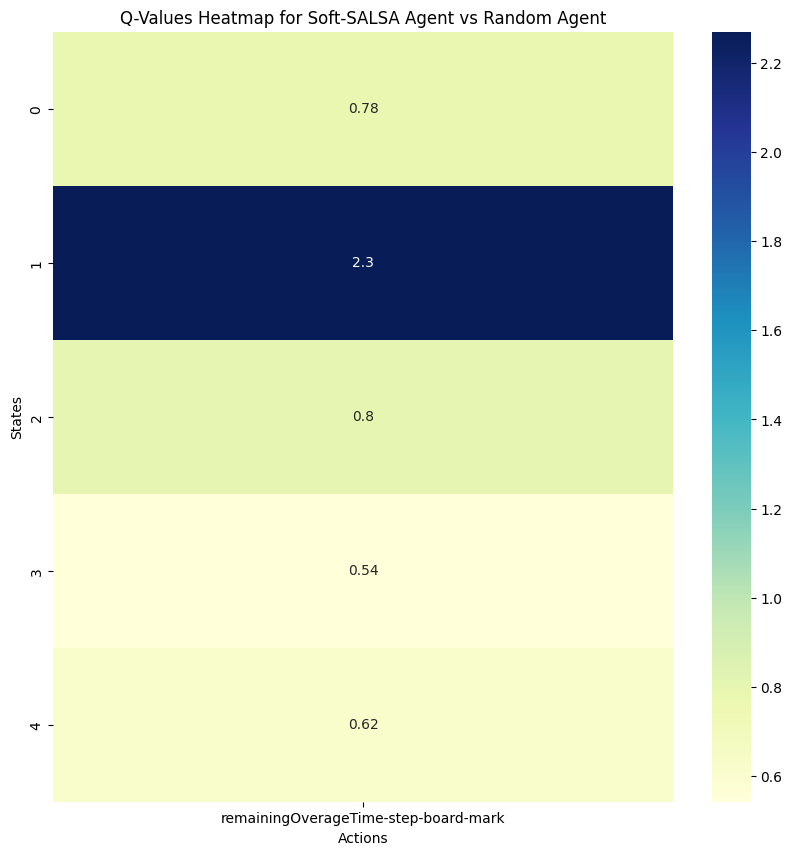

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#create a q-table from g_agent q-values
q_values_ss = agent.Q
q_values_ss_df = pd.DataFrame(q_values_ss)


# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(q_values_ss_df, annot=True, cmap="YlGnBu")
plt.title("Q-Values Heatmap for Soft-SALSA Agent vs Random Agent")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


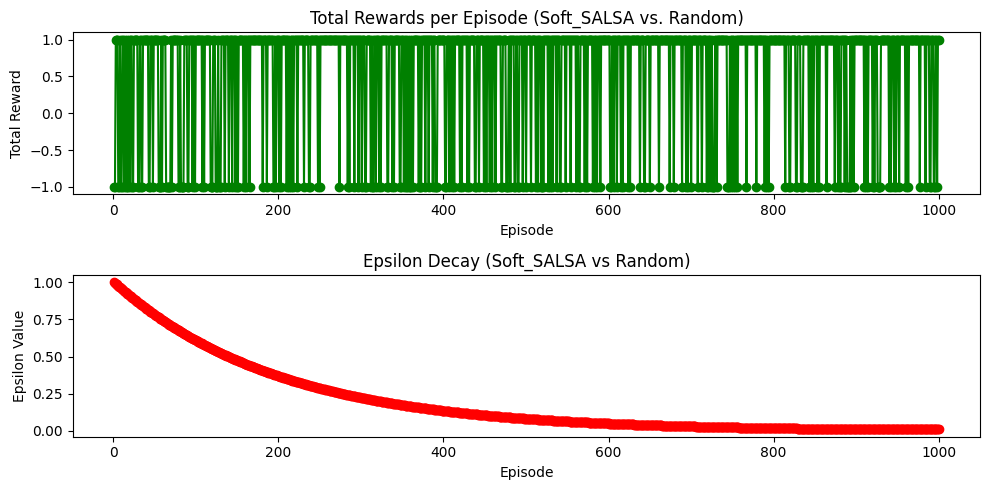

In [54]:
#Visualizing performance of Soft_SALSA vs. Random
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(episode_list, reward_list, marker = 'o', color='g')
plt.title('Total Rewards per Episode (Soft_SALSA vs. Random)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 1, 2)
plt.plot(episode_list, epsilon_list, marker='o', color='r')
plt.title('Epsilon Decay (Soft_SALSA vs Random)')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.show()

In [56]:
wr_ss = reward_list.count(1)/len(reward_list)

print(wr_ss)

0.746


In [57]:
#Soft_SALSA vs. Negamax
n_agent = Soft_SALSA(env)
trainer = env.train([None, 'negamax'])
epl_SS_N  = []
rel_SS_N = []
epsl_SS_N =[]
steps = 250
e_min = .01
e_decay = 0.995  # This is a common choice for e_decay

for episode in range(1000):
    obs = trainer.reset()
    done = False
    total_reward = 0


    while not done:
        action = int(n_agent.act(obs))  # Convert the action to an integer
        action_for_env = [action, None]  # The first agent's action (your agent's action)
        next_obs, reward, done, info = trainer.step(action)
        next_action = int(n_agent.act(next_obs))  # Choose next action based on next observation
        n_agent.learn(obs, action, reward, next_obs, next_action)  # Update Q-values
        obs = next_obs
        if reward is not None:  # Check if reward is not None
            total_reward += reward

        # Storing data in lists
    epl_SS_N.append(episode + 1)
    rel_SS_N.append(total_reward)
    epsl_SS_N.append(n_agent.epsilon)
    n_agent.epsilon *= e_decay

    if n_agent.epsilon < e_min:
        n_agent.epsilon = e_min

    if done:
        print('reward:' +str(reward)+ '( win = 1; lose = -1, draw = 0)')
        #env.render(mode='ipython')
        obs = trainer.reset()

reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1

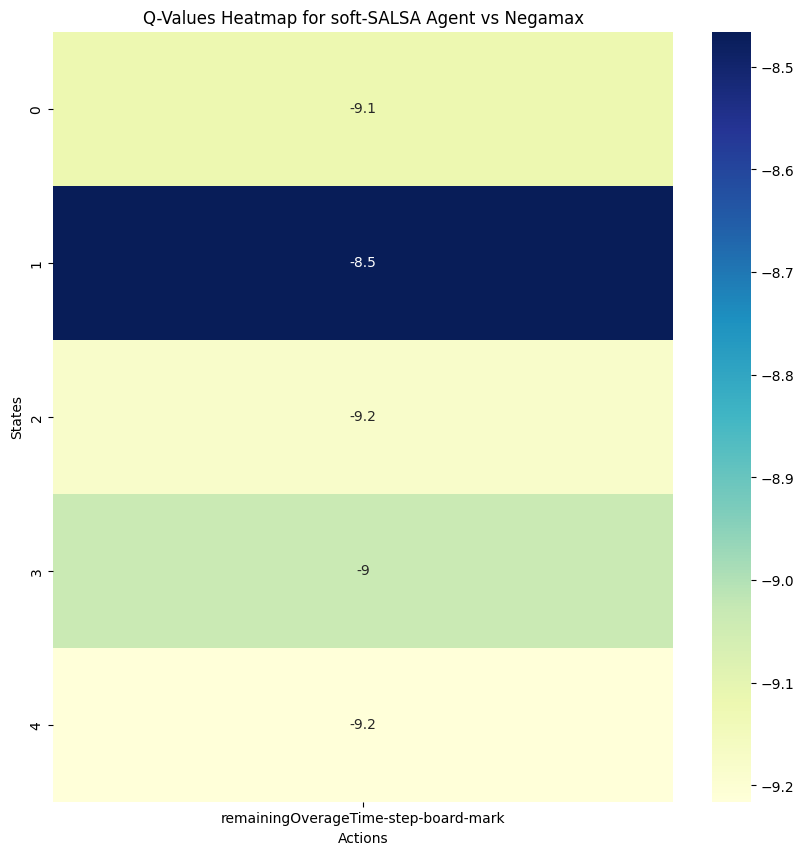

In [58]:
#create a q-table from  q-values
q_values_1 = n_agent.Q
q_values_df_1 = pd.DataFrame(q_values_1)


# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(q_values_df_1, annot=True, cmap="YlGnBu")
plt.title("Q-Values Heatmap for soft-SALSA Agent vs Negamax")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


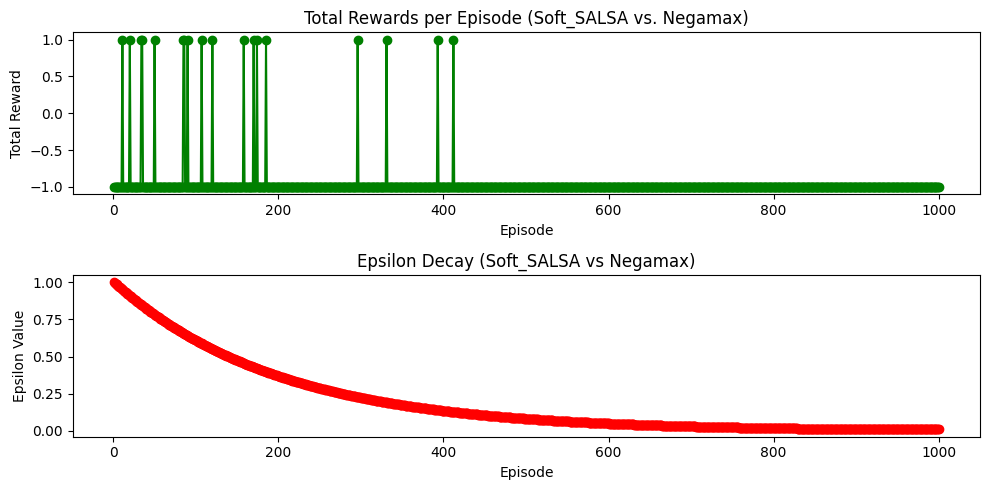

In [59]:
import matplotlib.pyplot as plt

#Visualizing performance of Soft_SALSA vs. Negamax
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epl_SS_N, rel_SS_N, marker = 'o', color='g')
plt.title('Total Rewards per Episode (Soft_SALSA vs. Negamax)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 1, 2)
plt.plot(epl_SS_N, epsl_SS_N, marker='o', color='r')
plt.title('Epsilon Decay (Soft_SALSA vs Negamax)')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.show()

In [60]:
wr_ss_n = rel_SS_N.count(1)/len(rel_SS_N)

print(wr_ss_n)

0.018


## Agent 2: Greedy_Salsa (Sarsa Lambda Agent)
This agent is similar to the first one, as both consider SARSA methods to function, however, this agent is a Sarsa($\lambda$) agent. In this instance, the agent uses eligibility traces to speed up its learning. This agent also uses $\epsilon$-greedy action selection as opposed to the $\epsilon$-soft action selection from Soft_SALSA


In [61]:
class Greedy_SALSA(object):

    def __init__(self, env, lambd=0.9):
        self.obs_space_salsa = (4,5)
        self.act_space_salsa = env.configuration['columns']
        self.Q = defaultdict(lambda: np.zeros(self.act_space_salsa))
        self.E = defaultdict(lambda: np.zeros(self.act_space_salsa))  # Eligibility traces
        self.alpha = 0.05  # Learning rate
        self.gamma = .98
        self.epsilon = 1
        self.lambd = lambd  # Decay rate for eligibility traces

    def act(self, obs):
        obs_tuple = tuple(obs)
        valid_moves = [col for col in range(self.act_space_salsa) if obs.board[col] == 0]
        q_values = self.Q[obs_tuple]

        if np.random.random() < 1 - self.epsilon:
            # Select the action with the highest Q-value
            greedy_action = np.argmax(q_values)
            action = valid_moves[greedy_action] if greedy_action < len(valid_moves) else np.random.choice(valid_moves)
        else:
            # Select a random action
            action = np.random.choice(valid_moves)

        return action

    def update_Q(self, obs, action, reward, next_obs, next_action):
        obs_q = tuple(obs)
        obs_next = tuple(next_obs)
        old_Q = self.Q[obs_q][action]
        new_Q = reward + self.gamma * self.Q[obs_next][next_action]
        delta = new_Q - old_Q

        # Update eligibility trace for current state-action
        self.E[obs_q][action] += 1

        # Update Q-values and eligibility traces for all state-action pairs
        for s in self.Q:
            for a in range(self.act_space_salsa):
                self.Q[s][a] += self.alpha * delta * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lambd

    def learn(self, obs, action, reward, next_obs, next_action):
        # Update Q-value for current state-action pair using SARSA update
        self.update_Q(obs, action, reward, next_obs, next_action)

In [62]:
#training greedy agent vs random agent
g_agent = Greedy_SALSA(env)
trainer_g = env.train([None, 'random'])
episode_list_g  = []
reward_list_g = []
epsilon_list_g =[]
steps_g = 250
e_min_g = .01
e_decay_g = .995

for episode_g in range(1000):
    obs = trainer_g.reset()
    done = False
    total_reward_g = 0


    while not done:
        action = int(g_agent.act(obs))  # Convert the action to an integer
        action_for_env = [action, None]  # The first agent's action (your agent's action)
        next_obs, reward, done, info = trainer_g.step(action)
        next_action = int(g_agent.act(next_obs))  # Choose next action based on next observation
        g_agent.learn(obs, action, reward, next_obs, next_action)  # Update Q-values
        obs = next_obs
        if reward is not None:  # Check if reward is not None
            total_reward_g += reward

        # Storing data in lists
    episode_list_g.append(episode_g + 1)
    reward_list_g.append(total_reward_g)
    epsilon_list_g.append(g_agent.epsilon)
    g_agent.epsilon *= e_decay_g

    if g_agent.epsilon < e_min_g:
        g_agent.epsilon = e_min_g

    if done:
        print('reward:' +str(reward)+ '( win = 1; lose = -1, draw = 0)')
        #env.render(mode='ipython')
        obs = trainer_g.reset()

reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1,

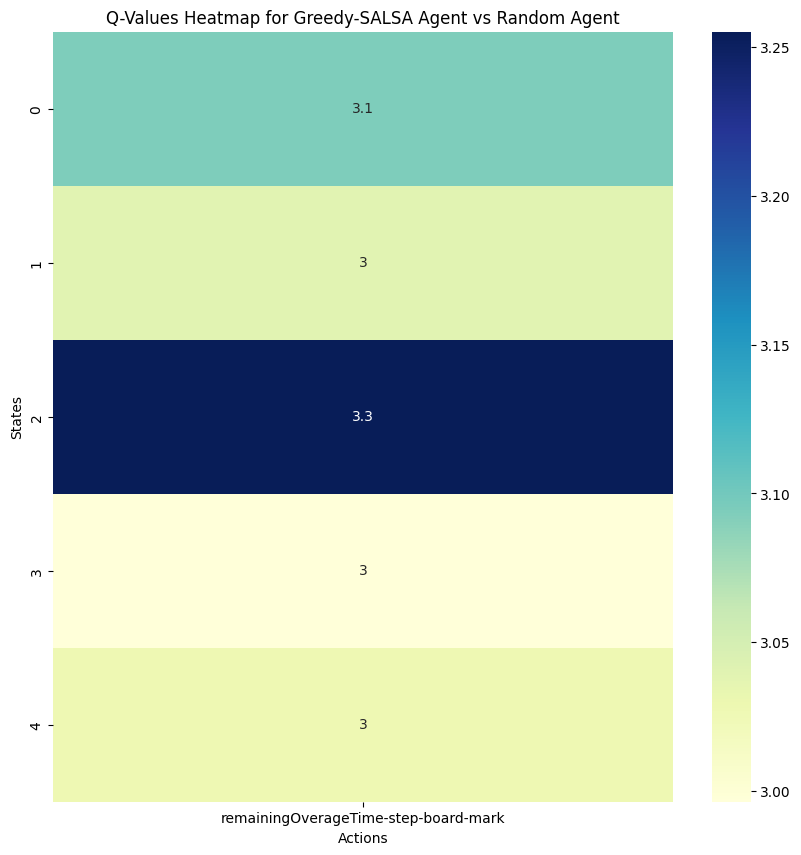

In [63]:
#create a q-table from g_agent q-values
q_values_g = g_agent.Q
q_values_df_g = pd.DataFrame(q_values_g)


# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(q_values_df_g, annot=True, cmap="YlGnBu")
plt.title("Q-Values Heatmap for Greedy-SALSA Agent vs Random Agent")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


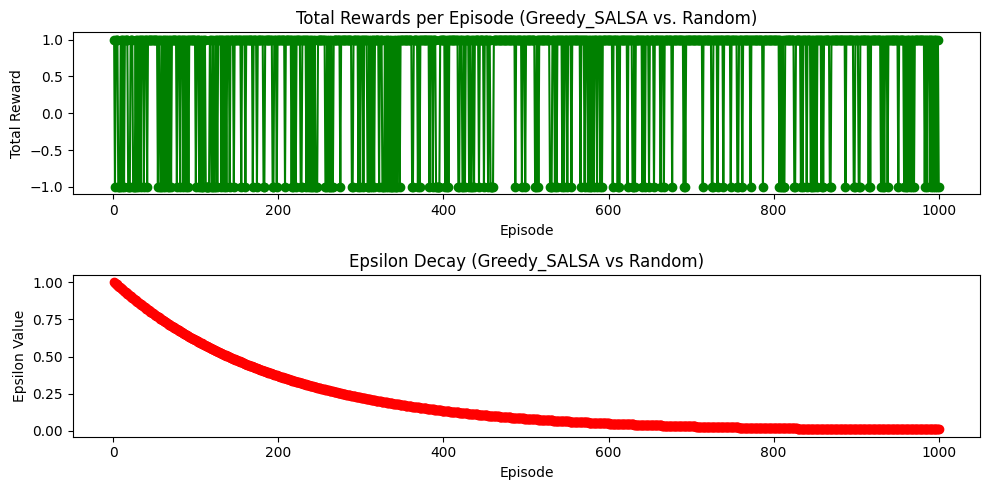

In [64]:
#Visualizing performance of Greedy SALSA vs. Random
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(episode_list_g, reward_list_g, marker = 'o', color='g')
plt.title('Total Rewards per Episode (Greedy_SALSA vs. Random)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 1, 2)
plt.plot(episode_list_g, epsilon_list_g, marker='o', color='r')
plt.title('Epsilon Decay (Greedy_SALSA vs Random)')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.show()

In [65]:
winrate_g_salsa = reward_list_g.count(1)/len(reward_list_g)
print(winrate_g_salsa)

0.771


In [66]:
#training greedy agent vs negamax agent
g_agent = Greedy_SALSA(env)
trainer_g = env.train([None, 'negamax'])
episode_list_g_n  = []
reward_list_g_n = []
epsilon_list_g_n =[]
steps_g = 250
e_min_g = .01
e_decay_g = .995

for episode_g in range(1000):
    obs = trainer_g.reset()
    done = False
    total_reward_g = 0


    while not done:
        action = int(g_agent.act(obs))  # Convert the action to an integer
        action_for_env = [action, None]  # The first agent's action (your agent's action)
        next_obs, reward, done, info = trainer_g.step(action)
        next_action = int(g_agent.act(next_obs))  # Choose next action based on next observation
        g_agent.learn(obs, action, reward, next_obs, next_action)  # Update Q-values
        obs = next_obs
        if reward is not None:  # Check if reward is not None
            total_reward_g += reward

        # Storing data in lists
    episode_list_g_n.append(episode_g + 1)
    reward_list_g_n.append(total_reward_g)
    epsilon_list_g_n.append(g_agent.epsilon)
    g_agent.epsilon *= e_decay_g

    if g_agent.epsilon < e_min_g:
        g_agent.epsilon = e_min_g

    if done:
        print('reward:' +str(reward)+ '( win = 1; lose = -1, draw = 0)')
        #env.render(mode='ipython')
        obs = trainer_g.reset()

reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1; lose = -1, draw = 0)
reward:-1( win = 1

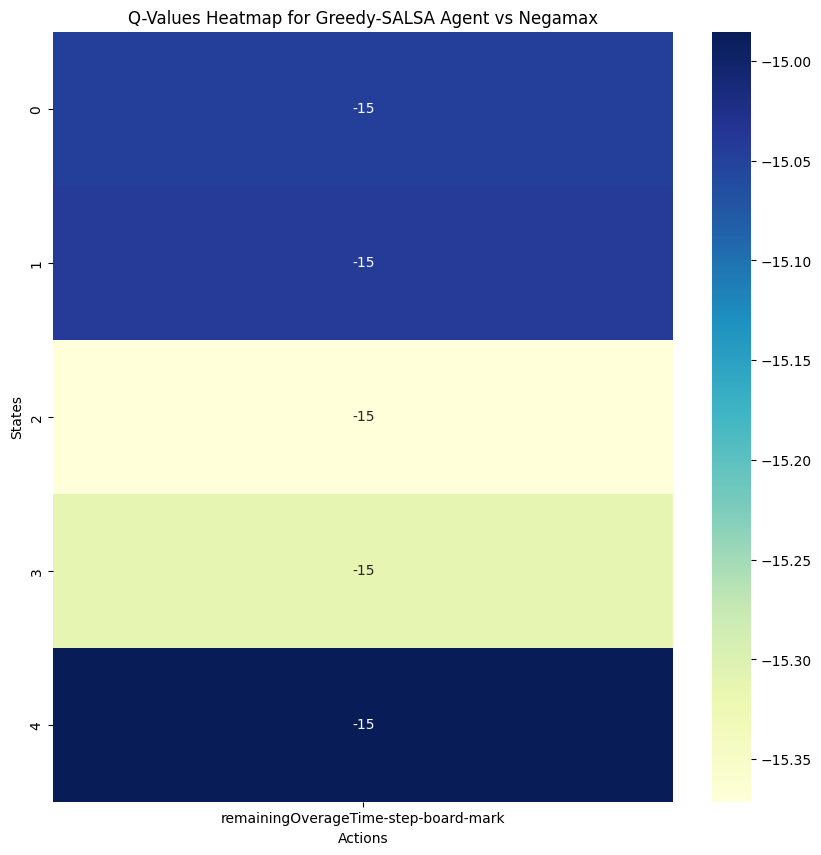

In [67]:
#create a q-table from g_agent q-values
q_values_g = g_agent.Q
q_values_df_g = pd.DataFrame(q_values_g)


# Create heatmap
plt.figure(figsize=(10,10))
sns.heatmap(q_values_df_g, annot=True, cmap="YlGnBu")
plt.title("Q-Values Heatmap for Greedy-SALSA Agent vs Negamax")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


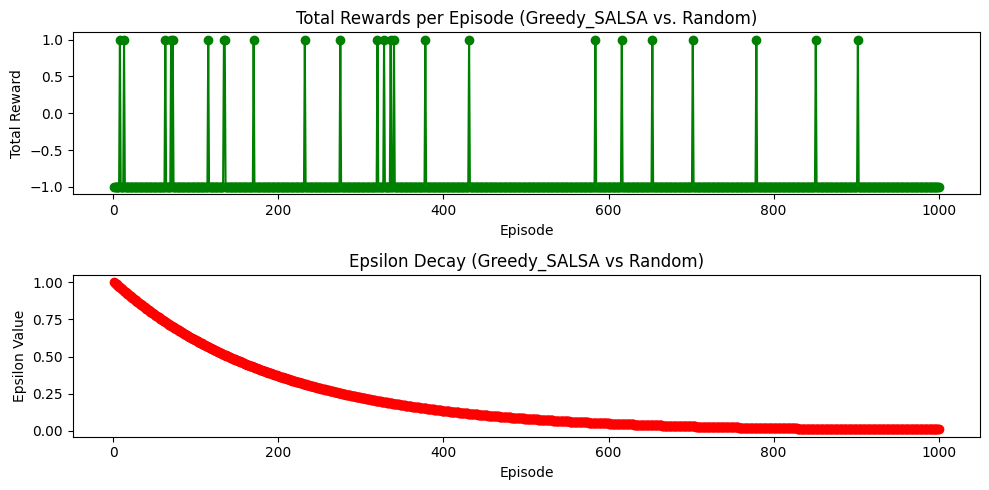

In [68]:
#Visualizing performance of Greedy SALSA vs. Random
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(episode_list_g_n, reward_list_g_n, marker = 'o', color='g')
plt.title('Total Rewards per Episode (Greedy_SALSA vs. Random)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 1, 2)
plt.plot(episode_list_g_n, epsilon_list_g_n, marker='o', color='r')
plt.title('Epsilon Decay (Greedy_SALSA vs Random)')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.show()

In [69]:
winrate_g_salsa_n = reward_list_g_n.count(1)/len(reward_list_g_n)
print(winrate_g_salsa_n)

0.024
